In [ ]:
import os
import pathlib
import shutil
import cv2
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile
from google.colab import drive
import seaborn as sns
from collections import Counter
from sklearn.utils import class_weight

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import  image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = "/content/drive/My Drive/SplitData_all.zip"

extract_path = "/content/"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
fixed_class_order = [
    #'Atelectasis',
    #'Cardiomegaly',
    #'Consolidation',
    #'Edema',
    'Effusion',
    #'Emphysema',
    #'Fibrosis',
    #'Hernia',
    #'Infiltration',
    #'Mass',
    'No Finding'
    #'Nodule',
    #'Pleural_Thickening',
    #'Pneumonia',
    #'Pneumothorax'
]

In [ ]:
class ReadDataset:
    def __init__(self, datasetpath, fixed_class_order, image_shape):
        self.datasetpath = datasetpath
        self.fixed_class_order = fixed_class_order
        self.image_shape = image_shape

    def readImages(self):
        self.finalImages = []
        labels = []

        for label_idx, class_name in enumerate(self.fixed_class_order):
            image_path = pathlib.Path(os.path.join(self.datasetpath, class_name))
            for img_path in image_path.glob('*.jpg'):
                img = cv2.imread(str(img_path))
                if img is not None:
                    img = cv2.resize(img, self.image_shape)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = (img / 255.0 - 0.5) / 0.5
                    self.finalImages.append(img)
                    labels.append(label_idx)

        return np.array(self.finalImages), np.array(labels)

In [ ]:
readDatasetObject = ReadDataset('/content/SplitData_all/train', fixed_class_order, (128, 128))

images, labels = readDatasetObject.readImages()

In [ ]:
print(f"Shape of images: {images.shape}\nShape of labels: {labels.shape}")

print(sorted(Counter(labels).items()))

Shape of images: (6977, 128, 128, 3)
Shape of labels: (6977,)
[(np.int64(0), 1977), (np.int64(1), 5000)]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Parameters
# CovidGAN: batch_size = 64, learning_rate = 0.0002, beta = 0.5 (beta is the momentum of Adam optimizer), number of epochs = 2000.
# CovidGAN has approximately 24 million parameters and it takes around 5 hours to train the model.
# Covid, Pnaumonia, Normal IAGAN trained for 250 epochs, 32 batch size, learning
# rates of 0.0004 and 0.0001 were used for the discriminator and generator, respectively.
latent_dim = 100
num_classes = len(fixed_class_order)
img_shape = (3, 128, 128)
batch_size = 32
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_epochs = 150
sample_interval = 5000

In [ ]:
# Data preparation
# Numpy Arrays to PyTorch Tensors and resizing (N,H,W,C) -> (N,C,H,W)
images_tensor = torch.FloatTensor(images).permute(0, 3, 1, 2).to(device)
labels_tensor = torch.LongTensor(labels).to(device)

# sapmles check and resizing
min_samples = min(images_tensor.size(0), labels_tensor.size(0))
images_tensor = images_tensor[:min_samples]
labels_tensor = labels_tensor[:min_samples]

print(f"Final images tensor shape: {images_tensor.shape}")
print(f"Final labels tensor shape: {labels_tensor.shape}")

# DataLoader
dataset = TensorDataset(images_tensor, labels_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Final images tensor shape: torch.Size([6977, 3, 128, 128])
Final labels tensor shape: torch.Size([6977])


In [ ]:
# Generator ACGAN
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_embedding = nn.Embedding(num_classes, latent_dim)

        self.init_size = img_shape[1] // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, img_shape[0], 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_embedding(labels), noise)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [ ]:
# Discriminator ACGAN
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                     nn.LeakyReLU(0.2, inplace=True)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(img_shape[0], 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        ds_size = img_shape[1] // 2 ** 4

        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Linear(128 * ds_size ** 2, num_classes)  # torch.nn.CrossEntropyLoss() expect logits, not softmax result

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)
        return validity, label


In [ ]:
# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Create output directory
os.makedirs("acgan_images", exist_ok=True)

In [ ]:
# Directories for training images
for pathology in fixed_class_order:
    os.makedirs(f"acgan_images/{pathology}", exist_ok=True)

g_losses = []
d_losses = []

# Training
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(tqdm(dataloader)):

        batch_size = imgs.shape[0]

        valid = torch.ones((batch_size, 1), device=device)
        fake = torch.zeros((batch_size, 1), device=device)

        # Train Generator
        optimizer_G.zero_grad()

        z = torch.randn(batch_size, latent_dim, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size,), device=device)

        gen_imgs = generator(z, gen_labels)
        validity, pred_label = discriminator(gen_imgs)
        # minimization of BCE L_source (real/fake loss) where D(G(n)) wants to be correct
        g_loss_source = adversarial_loss(validity, valid)   # log (D(G(n, c_g))
        g_loss_class = auxiliary_loss(pred_label, gen_labels)   # log P(c=c_g|G(n, c_g))
        g_loss =  g_loss_class + g_loss_source

        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()

        # Discriminator outputs
        real_pred, real_aux = discriminator(imgs)

        d_real_loss_source = adversarial_loss(real_pred, valid)   # log D(r)
        d_real_loss_class = auxiliary_loss(real_aux, labels)   # log P(c=c_r|r)

        fake_pred, fake_aux = discriminator(gen_imgs.detach())

        d_fake_loss_source = adversarial_loss(fake_pred, fake)   # log (1 -D(G(n, c_g))
        d_fake_loss_class = auxiliary_loss(fake_aux, gen_labels)   # log P(c=c_g|G(n, c_g))

        d_loss_source = d_real_loss_source + d_fake_loss_source
        d_loss_class = d_real_loss_class + d_fake_loss_class

        d_loss =  d_loss_class + d_loss_source

        d_loss.backward()
        optimizer_D.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())
    print(
        f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}] "
        f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
    )
    with torch.no_grad():
        # Generate and save sample images for each class
        samples_per_class = 1  # how many samples to generate per class
        for class_idx, class_name in enumerate(fixed_class_order):
            # Generate random noise
            z = torch.randn(samples_per_class, latent_dim, device=device)
            # Create labels for this class
            labels = torch.full((samples_per_class,), class_idx, dtype=torch.long, device=device)

            # Generate images
            gen_imgs = generator(z, labels)

            # Save each generated image
            for img_idx, img in enumerate(gen_imgs):
                save_image(img, f"acgan_images/{class_name}/epoch{epoch}_{img_idx}.png", normalize=True)

100%|██████████| 219/219 [00:15<00:00, 14.48it/s]


[Epoch 0/150] [Batch 218/219] [D loss: 4.3335] [G loss: 0.7398]


100%|██████████| 219/219 [00:12<00:00, 16.87it/s]


[Epoch 1/150] [Batch 218/219] [D loss: 2.6027] [G loss: 0.7361]


100%|██████████| 219/219 [00:12<00:00, 16.86it/s]


[Epoch 2/150] [Batch 218/219] [D loss: 2.0641] [G loss: 0.6678]


100%|██████████| 219/219 [00:13<00:00, 16.73it/s]


[Epoch 3/150] [Batch 218/219] [D loss: 2.0720] [G loss: 1.1882]


100%|██████████| 219/219 [00:13<00:00, 16.52it/s]


[Epoch 4/150] [Batch 218/219] [D loss: 1.5776] [G loss: 0.7703]


100%|██████████| 219/219 [00:13<00:00, 16.29it/s]


[Epoch 5/150] [Batch 218/219] [D loss: 1.7735] [G loss: 0.8344]


100%|██████████| 219/219 [00:13<00:00, 16.16it/s]


[Epoch 6/150] [Batch 218/219] [D loss: 1.8169] [G loss: 1.0503]


100%|██████████| 219/219 [00:13<00:00, 16.33it/s]


[Epoch 7/150] [Batch 218/219] [D loss: 1.4596] [G loss: 0.7335]


100%|██████████| 219/219 [00:13<00:00, 16.44it/s]


[Epoch 8/150] [Batch 218/219] [D loss: 2.4001] [G loss: 1.0514]


100%|██████████| 219/219 [00:13<00:00, 16.53it/s]


[Epoch 9/150] [Batch 218/219] [D loss: 0.9039] [G loss: 1.0327]


100%|██████████| 219/219 [00:13<00:00, 16.57it/s]


[Epoch 10/150] [Batch 218/219] [D loss: 2.9484] [G loss: 1.0049]


100%|██████████| 219/219 [00:13<00:00, 16.49it/s]


[Epoch 11/150] [Batch 218/219] [D loss: 1.9966] [G loss: 0.9097]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 12/150] [Batch 218/219] [D loss: 2.6168] [G loss: 0.7726]


100%|██████████| 219/219 [00:13<00:00, 16.43it/s]


[Epoch 13/150] [Batch 218/219] [D loss: 1.9670] [G loss: 0.3727]


100%|██████████| 219/219 [00:13<00:00, 16.42it/s]


[Epoch 14/150] [Batch 218/219] [D loss: 1.5693] [G loss: 0.8199]


100%|██████████| 219/219 [00:13<00:00, 16.43it/s]


[Epoch 15/150] [Batch 218/219] [D loss: 2.0234] [G loss: 0.9308]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 16/150] [Batch 218/219] [D loss: 1.8502] [G loss: 0.9806]


100%|██████████| 219/219 [00:13<00:00, 16.48it/s]


[Epoch 17/150] [Batch 218/219] [D loss: 1.2944] [G loss: 0.9746]


100%|██████████| 219/219 [00:13<00:00, 16.48it/s]


[Epoch 18/150] [Batch 218/219] [D loss: 1.5445] [G loss: 1.0433]


100%|██████████| 219/219 [00:13<00:00, 16.48it/s]


[Epoch 19/150] [Batch 218/219] [D loss: 2.0985] [G loss: 0.9451]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 20/150] [Batch 218/219] [D loss: 2.2637] [G loss: 0.3839]


100%|██████████| 219/219 [00:13<00:00, 16.43it/s]


[Epoch 21/150] [Batch 218/219] [D loss: 2.5042] [G loss: 0.5844]


100%|██████████| 219/219 [00:13<00:00, 16.44it/s]


[Epoch 22/150] [Batch 218/219] [D loss: 1.7744] [G loss: 1.0829]


100%|██████████| 219/219 [00:13<00:00, 16.44it/s]


[Epoch 23/150] [Batch 218/219] [D loss: 1.4270] [G loss: 1.1024]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 24/150] [Batch 218/219] [D loss: 1.2268] [G loss: 0.7989]


100%|██████████| 219/219 [00:13<00:00, 16.47it/s]


[Epoch 25/150] [Batch 218/219] [D loss: 2.0750] [G loss: 0.9222]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 26/150] [Batch 218/219] [D loss: 1.2765] [G loss: 1.1197]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 27/150] [Batch 218/219] [D loss: 1.6898] [G loss: 1.0272]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 28/150] [Batch 218/219] [D loss: 1.8003] [G loss: 0.5166]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 29/150] [Batch 218/219] [D loss: 1.9005] [G loss: 0.7373]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 30/150] [Batch 218/219] [D loss: 1.7184] [G loss: 0.5304]


100%|██████████| 219/219 [00:13<00:00, 16.47it/s]


[Epoch 31/150] [Batch 218/219] [D loss: 1.5907] [G loss: 0.9706]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 32/150] [Batch 218/219] [D loss: 1.2742] [G loss: 0.7994]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 33/150] [Batch 218/219] [D loss: 1.8637] [G loss: 0.7987]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 34/150] [Batch 218/219] [D loss: 3.0390] [G loss: 0.7513]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 35/150] [Batch 218/219] [D loss: 1.5588] [G loss: 0.8526]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 36/150] [Batch 218/219] [D loss: 1.3776] [G loss: 0.7713]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 37/150] [Batch 218/219] [D loss: 1.6229] [G loss: 0.7813]


100%|██████████| 219/219 [00:13<00:00, 16.47it/s]


[Epoch 38/150] [Batch 218/219] [D loss: 1.5314] [G loss: 0.6503]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 39/150] [Batch 218/219] [D loss: 1.3912] [G loss: 0.9434]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 40/150] [Batch 218/219] [D loss: 1.7239] [G loss: 0.5866]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 41/150] [Batch 218/219] [D loss: 1.9753] [G loss: 0.5457]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 42/150] [Batch 218/219] [D loss: 2.8521] [G loss: 0.5404]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 43/150] [Batch 218/219] [D loss: 3.0271] [G loss: 0.8013]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 44/150] [Batch 218/219] [D loss: 0.8418] [G loss: 0.7403]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 45/150] [Batch 218/219] [D loss: 1.4209] [G loss: 0.5320]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 46/150] [Batch 218/219] [D loss: 3.8527] [G loss: 0.6775]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 47/150] [Batch 218/219] [D loss: 1.0484] [G loss: 1.0051]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 48/150] [Batch 218/219] [D loss: 1.8300] [G loss: 0.5638]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 49/150] [Batch 218/219] [D loss: 1.3519] [G loss: 0.6280]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 50/150] [Batch 218/219] [D loss: 1.5876] [G loss: 0.6790]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 51/150] [Batch 218/219] [D loss: 1.6807] [G loss: 0.5890]


100%|██████████| 219/219 [00:13<00:00, 16.47it/s]


[Epoch 52/150] [Batch 218/219] [D loss: 1.2196] [G loss: 0.9760]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 53/150] [Batch 218/219] [D loss: 3.5514] [G loss: 0.6559]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 54/150] [Batch 218/219] [D loss: 1.4595] [G loss: 0.6574]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 55/150] [Batch 218/219] [D loss: 2.0820] [G loss: 0.5555]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 56/150] [Batch 218/219] [D loss: 3.1811] [G loss: 0.7888]


100%|██████████| 219/219 [00:13<00:00, 16.44it/s]


[Epoch 57/150] [Batch 218/219] [D loss: 1.3697] [G loss: 0.7190]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 58/150] [Batch 218/219] [D loss: 1.5199] [G loss: 0.6531]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 59/150] [Batch 218/219] [D loss: 1.4445] [G loss: 0.8156]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 60/150] [Batch 218/219] [D loss: 1.5171] [G loss: 0.7981]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 61/150] [Batch 218/219] [D loss: 1.6890] [G loss: 0.7734]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 62/150] [Batch 218/219] [D loss: 2.6805] [G loss: 0.4336]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 63/150] [Batch 218/219] [D loss: 1.4494] [G loss: 0.7009]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 64/150] [Batch 218/219] [D loss: 1.6117] [G loss: 0.9618]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 65/150] [Batch 218/219] [D loss: 1.1165] [G loss: 0.6886]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 66/150] [Batch 218/219] [D loss: 1.7017] [G loss: 0.9924]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 67/150] [Batch 218/219] [D loss: 1.3467] [G loss: 0.7403]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 68/150] [Batch 218/219] [D loss: 1.4278] [G loss: 0.8743]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 69/150] [Batch 218/219] [D loss: 1.8327] [G loss: 0.5655]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 70/150] [Batch 218/219] [D loss: 1.8429] [G loss: 0.3940]


100%|██████████| 219/219 [00:13<00:00, 16.49it/s]


[Epoch 71/150] [Batch 218/219] [D loss: 1.3139] [G loss: 0.8277]


100%|██████████| 219/219 [00:13<00:00, 16.49it/s]


[Epoch 72/150] [Batch 218/219] [D loss: 1.6380] [G loss: 0.8529]


100%|██████████| 219/219 [00:13<00:00, 16.48it/s]


[Epoch 73/150] [Batch 218/219] [D loss: 1.1822] [G loss: 0.9326]


100%|██████████| 219/219 [00:13<00:00, 16.48it/s]


[Epoch 74/150] [Batch 218/219] [D loss: 1.3179] [G loss: 0.5876]


100%|██████████| 219/219 [00:13<00:00, 16.47it/s]


[Epoch 75/150] [Batch 218/219] [D loss: 1.1623] [G loss: 0.6129]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 76/150] [Batch 218/219] [D loss: 1.1462] [G loss: 0.7150]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 77/150] [Batch 218/219] [D loss: 1.5127] [G loss: 0.8237]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 78/150] [Batch 218/219] [D loss: 1.3102] [G loss: 0.7294]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 79/150] [Batch 218/219] [D loss: 1.2040] [G loss: 0.5876]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 80/150] [Batch 218/219] [D loss: 1.0039] [G loss: 0.8504]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 81/150] [Batch 218/219] [D loss: 2.0973] [G loss: 0.8619]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 82/150] [Batch 218/219] [D loss: 2.8099] [G loss: 1.0055]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 83/150] [Batch 218/219] [D loss: 2.7967] [G loss: 0.7002]


100%|██████████| 219/219 [00:13<00:00, 16.47it/s]


[Epoch 84/150] [Batch 218/219] [D loss: 1.1628] [G loss: 0.7875]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 85/150] [Batch 218/219] [D loss: 1.3236] [G loss: 0.9013]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 86/150] [Batch 218/219] [D loss: 1.2940] [G loss: 0.9613]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 87/150] [Batch 218/219] [D loss: 1.8809] [G loss: 0.8392]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 88/150] [Batch 218/219] [D loss: 2.4879] [G loss: 0.5695]


100%|██████████| 219/219 [00:13<00:00, 16.47it/s]


[Epoch 89/150] [Batch 218/219] [D loss: 1.2271] [G loss: 0.6377]


100%|██████████| 219/219 [00:13<00:00, 16.47it/s]


[Epoch 90/150] [Batch 218/219] [D loss: 1.2289] [G loss: 0.9030]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 91/150] [Batch 218/219] [D loss: 1.0010] [G loss: 0.9449]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 92/150] [Batch 218/219] [D loss: 1.4178] [G loss: 0.8454]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 93/150] [Batch 218/219] [D loss: 1.4348] [G loss: 0.5544]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 94/150] [Batch 218/219] [D loss: 1.1468] [G loss: 0.9884]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 95/150] [Batch 218/219] [D loss: 1.5389] [G loss: 0.8124]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 96/150] [Batch 218/219] [D loss: 1.7312] [G loss: 0.5008]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 97/150] [Batch 218/219] [D loss: 1.6298] [G loss: 0.8730]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 98/150] [Batch 218/219] [D loss: 1.3512] [G loss: 0.5441]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 99/150] [Batch 218/219] [D loss: 1.7107] [G loss: 0.5007]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 100/150] [Batch 218/219] [D loss: 1.1227] [G loss: 0.9124]


100%|██████████| 219/219 [00:13<00:00, 16.47it/s]


[Epoch 101/150] [Batch 218/219] [D loss: 1.3143] [G loss: 1.0959]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 102/150] [Batch 218/219] [D loss: 1.2215] [G loss: 0.8258]


100%|██████████| 219/219 [00:13<00:00, 16.44it/s]


[Epoch 103/150] [Batch 218/219] [D loss: 2.1193] [G loss: 0.9495]


100%|██████████| 219/219 [00:13<00:00, 16.43it/s]


[Epoch 104/150] [Batch 218/219] [D loss: 1.4251] [G loss: 0.9153]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 105/150] [Batch 218/219] [D loss: 1.4902] [G loss: 0.6032]


100%|██████████| 219/219 [00:13<00:00, 16.44it/s]


[Epoch 106/150] [Batch 218/219] [D loss: 1.4453] [G loss: 0.6544]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 107/150] [Batch 218/219] [D loss: 1.2651] [G loss: 0.7986]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 108/150] [Batch 218/219] [D loss: 1.4446] [G loss: 0.5848]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 109/150] [Batch 218/219] [D loss: 0.8440] [G loss: 0.9261]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 110/150] [Batch 218/219] [D loss: 2.2726] [G loss: 0.7144]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 111/150] [Batch 218/219] [D loss: 1.0851] [G loss: 0.8351]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 112/150] [Batch 218/219] [D loss: 1.2648] [G loss: 0.5744]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 113/150] [Batch 218/219] [D loss: 1.3596] [G loss: 0.6999]


100%|██████████| 219/219 [00:13<00:00, 16.47it/s]


[Epoch 114/150] [Batch 218/219] [D loss: 1.2685] [G loss: 0.6375]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 115/150] [Batch 218/219] [D loss: 1.2717] [G loss: 0.8139]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 116/150] [Batch 218/219] [D loss: 1.1035] [G loss: 0.7461]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 117/150] [Batch 218/219] [D loss: 0.8868] [G loss: 0.8009]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 118/150] [Batch 218/219] [D loss: 1.1433] [G loss: 0.8148]


100%|██████████| 219/219 [00:13<00:00, 16.47it/s]


[Epoch 119/150] [Batch 218/219] [D loss: 1.4390] [G loss: 0.5364]


100%|██████████| 219/219 [00:13<00:00, 16.48it/s]


[Epoch 120/150] [Batch 218/219] [D loss: 1.5789] [G loss: 0.6223]


100%|██████████| 219/219 [00:13<00:00, 16.47it/s]


[Epoch 121/150] [Batch 218/219] [D loss: 4.9160] [G loss: 4.1438]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 122/150] [Batch 218/219] [D loss: 1.4959] [G loss: 0.6208]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 123/150] [Batch 218/219] [D loss: 1.5297] [G loss: 0.4690]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 124/150] [Batch 218/219] [D loss: 1.1765] [G loss: 0.7570]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 125/150] [Batch 218/219] [D loss: 1.1189] [G loss: 1.3556]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 126/150] [Batch 218/219] [D loss: 2.0039] [G loss: 0.4798]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 127/150] [Batch 218/219] [D loss: 1.4515] [G loss: 1.0458]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 128/150] [Batch 218/219] [D loss: 0.9542] [G loss: 0.9626]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 129/150] [Batch 218/219] [D loss: 1.4664] [G loss: 0.6001]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 130/150] [Batch 218/219] [D loss: 1.8721] [G loss: 0.4699]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 131/150] [Batch 218/219] [D loss: 1.1171] [G loss: 0.8207]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 132/150] [Batch 218/219] [D loss: 1.5178] [G loss: 0.4201]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 133/150] [Batch 218/219] [D loss: 1.3310] [G loss: 0.7251]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 134/150] [Batch 218/219] [D loss: 1.4097] [G loss: 0.7443]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 135/150] [Batch 218/219] [D loss: 0.9778] [G loss: 0.7448]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 136/150] [Batch 218/219] [D loss: 1.5968] [G loss: 1.0791]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 137/150] [Batch 218/219] [D loss: 0.8394] [G loss: 0.7806]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 138/150] [Batch 218/219] [D loss: 1.3410] [G loss: 0.4405]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 139/150] [Batch 218/219] [D loss: 1.6964] [G loss: 0.7408]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 140/150] [Batch 218/219] [D loss: 1.6335] [G loss: 0.4476]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 141/150] [Batch 218/219] [D loss: 1.5257] [G loss: 0.9122]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 142/150] [Batch 218/219] [D loss: 1.2006] [G loss: 0.7471]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 143/150] [Batch 218/219] [D loss: 0.7922] [G loss: 0.9382]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 144/150] [Batch 218/219] [D loss: 1.7562] [G loss: 0.4915]


100%|██████████| 219/219 [00:13<00:00, 16.45it/s]


[Epoch 145/150] [Batch 218/219] [D loss: 1.2972] [G loss: 0.9327]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 146/150] [Batch 218/219] [D loss: 1.4707] [G loss: 0.6529]


100%|██████████| 219/219 [00:13<00:00, 16.47it/s]


[Epoch 147/150] [Batch 218/219] [D loss: 1.4276] [G loss: 0.6737]


100%|██████████| 219/219 [00:13<00:00, 16.47it/s]


[Epoch 148/150] [Batch 218/219] [D loss: 1.4155] [G loss: 0.9525]


100%|██████████| 219/219 [00:13<00:00, 16.46it/s]


[Epoch 149/150] [Batch 218/219] [D loss: 0.5792] [G loss: 1.1121]


In [ ]:
!zip -r /content/acgan128_Atl_NoF_training.zip /content/acgan_images

  adding: content/acgan_images/ (stored 0%)
  adding: content/acgan_images/Effusion/ (stored 0%)
  adding: content/acgan_images/Effusion/epoch85_0.png (stored 0%)
  adding: content/acgan_images/Effusion/epoch18_0.png (stored 0%)
  adding: content/acgan_images/Effusion/epoch19_0.png (stored 0%)
  adding: content/acgan_images/Effusion/epoch91_0.png (stored 0%)
  adding: content/acgan_images/Effusion/epoch14_0.png (deflated 0%)
  adding: content/acgan_images/Effusion/epoch16_0.png (deflated 0%)
  adding: content/acgan_images/Effusion/epoch144_0.png (stored 0%)
  adding: content/acgan_images/Effusion/epoch28_0.png (stored 0%)
  adding: content/acgan_images/Effusion/epoch83_0.png (stored 0%)
  adding: content/acgan_images/Effusion/epoch24_0.png (stored 0%)
  adding: content/acgan_images/Effusion/epoch49_0.png (stored 0%)
  adding: content/acgan_images/Effusion/epoch124_0.png (stored 0%)
  adding: content/acgan_images/Effusion/epoch74_0.png (stored 0%)
  adding: content/acgan_images/Effusion

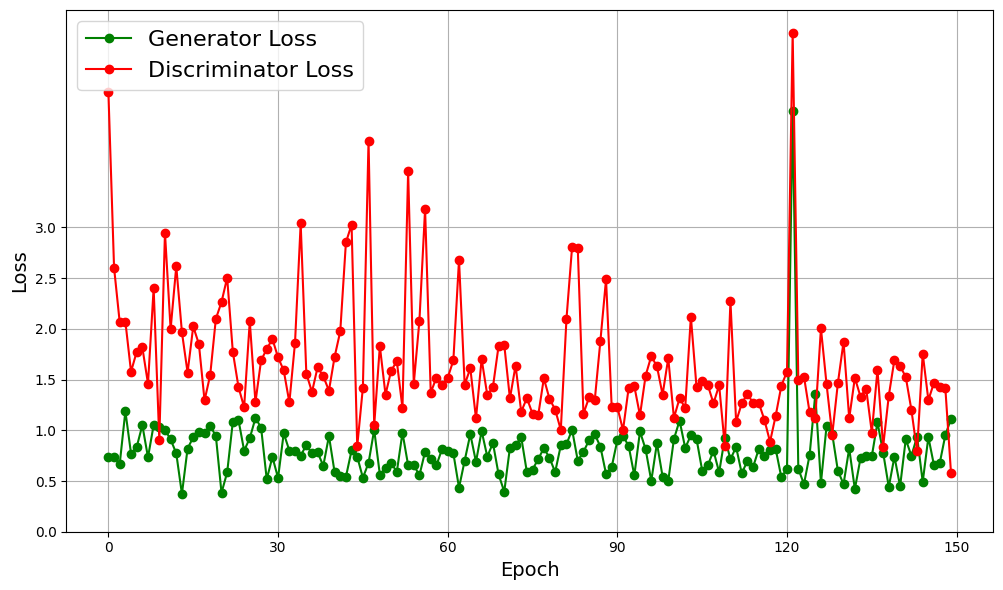

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(g_losses, 'g-o', label="Generator Loss", )
plt.plot(d_losses, "r-o", label="Discriminator Loss")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.xticks(np.arange(0, 150.1, 30))
plt.yticks(np.arange(0, 3.1, 0.5))
plt.savefig("acgan_training_losses.pdf", format='pdf')
plt.show()

In [ ]:
# Save models
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

## Generate images

In [ ]:
# Initialize generator (same architecture as during training)
generator = Generator().to(device)
generator.load_state_dict(torch.load("/content/generator.pth"))
generator.eval()  # Set to evaluation mode


# Create output directories
for val in fixed_class_order:
  os.makedirs(f"generated_images/train/{val}", exist_ok=True)





In [ ]:

def generate_images(class_label, num_images, batch_size=64):
    images_generated = 0
    while images_generated < num_images:
        # Calculate how many images to generate in this batch
        current_batch_size = min(batch_size, num_images - images_generated)

        # Generate noise and labels
        z = torch.randn(current_batch_size, latent_dim, device=device)
        labels = torch.full((current_batch_size,), class_label, dtype=torch.long, device=device)

        # Generate images
        with torch.no_grad():
            gen_imgs = generator(z, labels)
            #gen_imgs = (gen_imgs * 0.5) + 0.5  # Scale from [-1,1] to [0,1] if using tanh

        # Save images
        for i in range(current_batch_size):
            img_np = gen_imgs[i].cpu().numpy().transpose(1, 2, 0) * 255  # CHW to HWC, [0,255]
            img_np = img_np.astype(np.uint8)

            img_pil = Image.fromarray(img_np)
            img_path = os.path.join("generated_images/train",
                                  f"{fixed_class_order[class_label]}",
                                  f"gimg_{images_generated + i}.jpg")  # Note .jpg extension

            img_pil.save(img_path)

        images_generated += current_batch_size
    print(f"Generated {images_generated} images for class {fixed_class_order[class_label]}")

In [ ]:
#for i in range(2):
#  generate_images(class_label=i, num_images=1000)

generate_images(class_label=0, num_images=4023) # 4023 Eff
generate_images(class_label=1, num_images=1000) # 1000 Nof

print("All images generated successfully!")

Generated 4023 images for class Effusion
Generated 1000 images for class No Finding
All images generated successfully!


In [ ]:

shutil.rmtree('generated_images')
shutil.rmtree('classification_gan')

## Data prepatation

In [ ]:

def combine_datasets(split_images_dir, target_dir, selected_classes, processed_data_dir=None):
    """
    Combines train images from SplitImages and ProcessedData into single train directory,
    while preserving test/validation from SplitImages

    Args:
        split_images_dir: Path to SplitImages directory
        processed_data_dir: Path to ProcessedData directory (can be None)
        target_dir: Path where combined data will be saved
        selected_classes: List of class names to include
    """
    # Create target directory structure
    splits = ['train', 'val']

    for split in splits:
        for class_name in selected_classes:
            os.makedirs(os.path.join(target_dir, split, class_name), exist_ok=True)

    print(f"Combining data for classes: {', '.join(selected_classes)}")

    # 1. First copy all SplitImages data (train/test/validation)
    for split in ['train', 'val']:
        src_split_dir = os.path.join(split_images_dir, split)
        if not os.path.exists(src_split_dir):
            continue

        for class_name in tqdm(selected_classes, desc=f"Copying from SplitImages/{split}"):
            src_class_dir = os.path.join(src_split_dir, class_name)
            if not os.path.exists(src_class_dir):
                continue

            dst_class_dir = os.path.join(target_dir, split, class_name)

            for filename in os.listdir(src_class_dir):
                src_path = os.path.join(src_class_dir, filename)
                dst_path = os.path.join(dst_class_dir, filename)

                # Handle filename conflicts
                if os.path.exists(dst_path):
                    base, ext = os.path.splitext(filename)
                    counter = 1
                    while os.path.exists(dst_path):
                        new_filename = f"{base}_{counter}{ext}"
                        dst_path = os.path.join(dst_class_dir, new_filename)
                        counter += 1

                shutil.copy2(src_path, dst_path)

    # 2. Then merge ProcessedData train into target train (if provided)
    if processed_data_dir:
        src_processed_dir = os.path.join(processed_data_dir, 'train')
        dst_train_dir = os.path.join(target_dir, 'train')

        for class_name in tqdm(selected_classes, desc="Merging ProcessedData/train"):
            src_class_dir = os.path.join(src_processed_dir, class_name)
            if not os.path.exists(src_class_dir):
                continue

            dst_class_dir = os.path.join(dst_train_dir, class_name)

            for filename in os.listdir(src_class_dir):
                src_path = os.path.join(src_class_dir, filename)
                dst_path = os.path.join(dst_class_dir, filename)

                # Handle filename conflicts
                if os.path.exists(dst_path):
                    base, ext = os.path.splitext(filename)
                    counter = 1
                    while os.path.exists(dst_path):
                        new_filename = f"{base}_{counter}{ext}"
                        dst_path = os.path.join(dst_class_dir, new_filename)
                        counter += 1

                shutil.copy2(src_path, dst_path)

In [ ]:
combine_datasets(split_images_dir="/content/SplitData_all", processed_data_dir='/content/generated_images', target_dir='/content/classification_gan', selected_classes=[x for x in fixed_class_order])

Combining data for classes: Effusion, No Finding


Merging ProcessedData/train: 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]


In [ ]:
combine_datasets(split_images_dir="/content/SplitData_all", target_dir='/content/classification_unchanged', selected_classes=[x for x in fixed_class_order])

Combining data for classes: Effusion, No Finding


Copying from SplitImages/val: 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]


## Classification

### Pre-trained

In [ ]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 64
NUM_CLASSES = len(fixed_class_order)
EPOCHS = 30

In [ ]:


train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/SplitData_all/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    class_names=fixed_class_order
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/SplitData_all/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    class_names=fixed_class_order
)

Found 6977 files belonging to 2 classes.
Found 6978 files belonging to 2 classes.


In [ ]:
class_names = train_dataset.class_names
print("Class mapping:", dict(enumerate(class_names)))

Class mapping: {0: 'Effusion', 1: 'No Finding'}


In [ ]:
train_dataset_generated = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/classification_gan/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    class_names=fixed_class_order
)

Found 12000 files belonging to 2 classes.


### Simple CNN architecture

In [ ]:
model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(128, 128, 3)))

model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.build()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,202,308 (19.85 MB)

 Trainable params: 2,601,153 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,601,155 (9.92 MB)

In [ ]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset
)

Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8727 - loss: 0.3058 - val_accuracy: 0.6326 - val_loss: 0.7126
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8789 - loss: 0.2953 - val_accuracy: 0.7608 - val_loss: 0.5487
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8830 - loss: 0.2793 - val_accuracy: 0.7406 - val_loss: 0.6258
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8839 - loss: 0.2774 - val_accuracy: 0.7684 - val_loss: 0.5063
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8923 - loss: 0.2667 - val_accuracy: 0.7660 - val_loss: 0.5070
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9013 - loss: 0.2513 - val_accuracy: 0.7267 - val_loss: 0.5771
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9029 - loss: 0.2466 - val_accuracy: 0.7157 - val_loss: 0.6420
Epoch 8/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8967 - loss: 0.2522 - val_accu

In [ ]:
model.save('cnn_no_augmentation.keras')

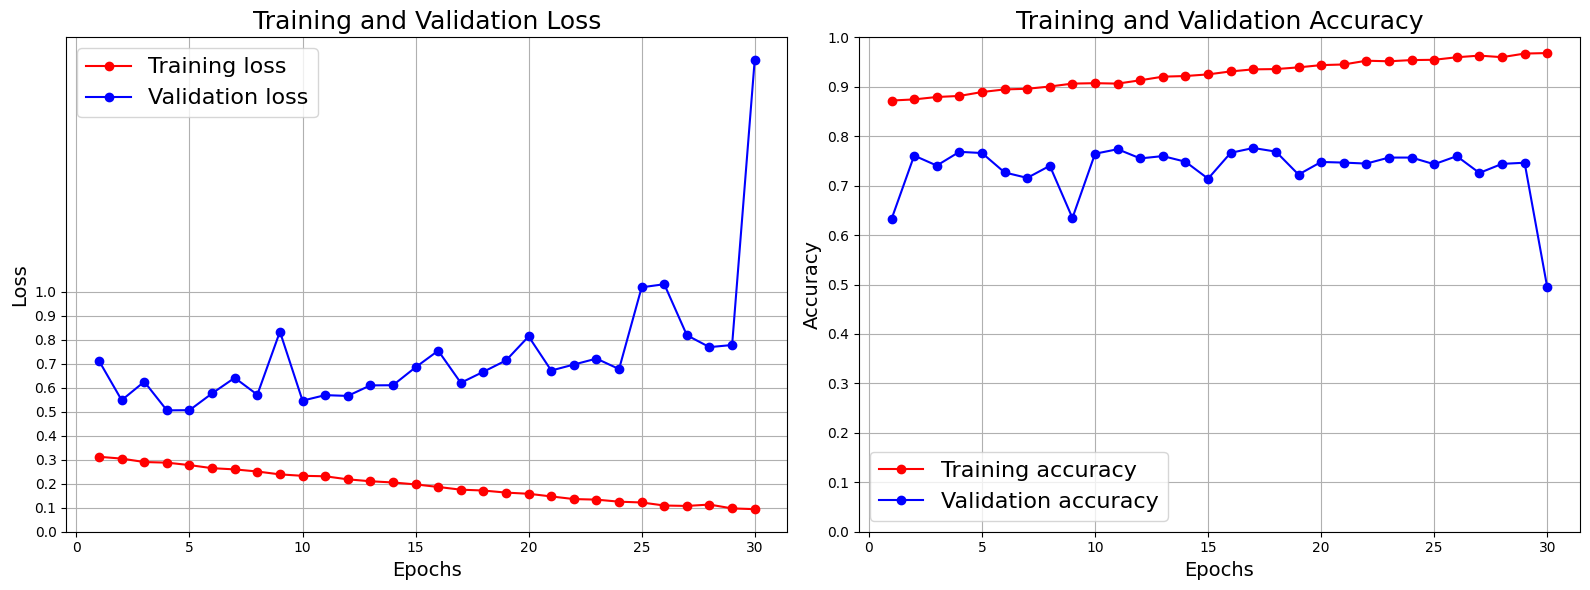

In [ ]:
history_dict = history.history
history_dict.keys()

epochs = range(1, len(history_dict['accuracy']) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(epochs, history_dict['loss'], 'r-o', label='Training loss')
ax1.plot(epochs, history_dict['val_loss'], 'b-o', label='Validation loss')
ax1.set_title('Training and Validation Loss', fontsize=18)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=16)

loss_ticks = np.arange(0, 1.1, 0.1)
ax1.set_yticks(loss_ticks)

ax2.plot(epochs, history_dict['accuracy'], 'r-o', label='Training accuracy')
ax2.plot(epochs, history_dict['val_accuracy'], 'b-o', label='Validation accuracy')
ax2.set_title('Training and Validation Accuracy', fontsize=18)
ax2.set_xlabel('Epochs', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.grid(True)
ax2.legend(fontsize=16)

accuracy_ticks = np.arange(0, 1.1, 0.1)
ax2.set_yticks(accuracy_ticks)

plt.tight_layout()
plt.savefig("CNN_training_no_aug.pdf", format='pdf')
plt.show()

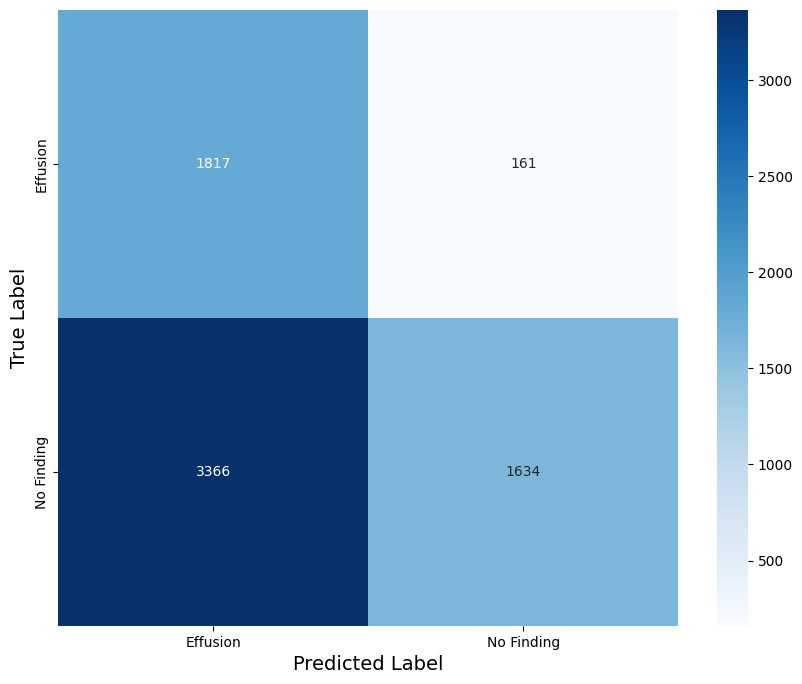

In [ ]:

class_names = train_dataset.class_names

y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.savefig("CNN_ConfusionMatrix_no_aug.pdf", format='pdf')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.35      0.92      0.51      1978
         1.0       0.91      0.33      0.48      5000

    accuracy                           0.49      6978
   macro avg       0.63      0.62      0.49      6978
weighted avg       0.75      0.49      0.49      6978



### GRAD CAM algorithm for visualizing heatmap (+ boundingbox?)

In [ ]:
def visualize_heatmap():
  pass

### data augmentation (Eff += 1500)

In [ ]:
model.build()

In [ ]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_dataset_generated,
    epochs=30,
    validation_data=val_dataset,
)

history_dict = history.history
history_dict.keys()

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.6905 - loss: 0.5976 - val_accuracy: 0.7158 - val_loss: 0.5549
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7554 - loss: 0.4905 - val_accuracy: 0.7750 - val_loss: 0.5234
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7560 - loss: 0.4760 - val_accuracy: 0.7813 - val_loss: 0.4955
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7723 - loss: 0.4599 - val_accuracy: 0.7954 - val_loss: 0.4826
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7779 - loss: 0.4470 - val_accuracy: 0.7519 - val_loss: 0.4905
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7802 - loss: 0.4376 - val_accuracy: 0.7729 - val_loss: 0.4669
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7883 - loss: 0.4306 - val_accuracy: 0.7585 - val_loss: 0.4933
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7964 - loss: 0.4191 - val_acc

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

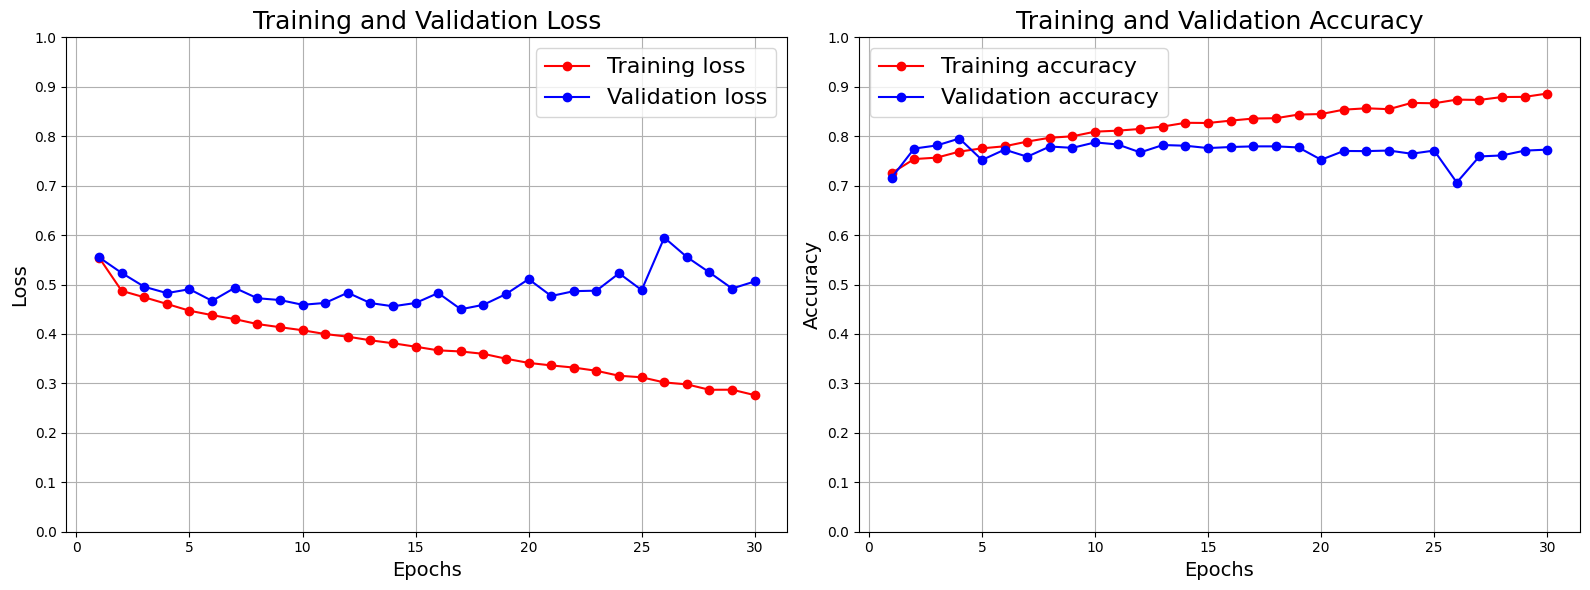

In [ ]:
epochs = range(1, len(history_dict['accuracy']) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(epochs, history_dict['loss'], 'r-o', label='Training loss')
ax1.plot(epochs, history_dict['val_loss'], 'b-o', label='Validation loss')
ax1.set_title('Training and Validation Loss', fontsize=18)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=16)

loss_ticks = np.arange(0, 1.1, 0.1)
ax1.set_yticks(loss_ticks)

ax2.plot(epochs, history_dict['accuracy'], 'r-o', label='Training accuracy')
ax2.plot(epochs, history_dict['val_accuracy'], 'b-o', label='Validation accuracy')
ax2.set_title('Training and Validation Accuracy', fontsize=18)
ax2.set_xlabel('Epochs', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.grid(True)
ax2.legend(fontsize=16)

accuracy_ticks = np.arange(0, 1.1, 0.1)
ax2.set_yticks(accuracy_ticks)

plt.tight_layout()
plt.savefig("CNN_training_aug.pdf", format='pdf')
plt.show()

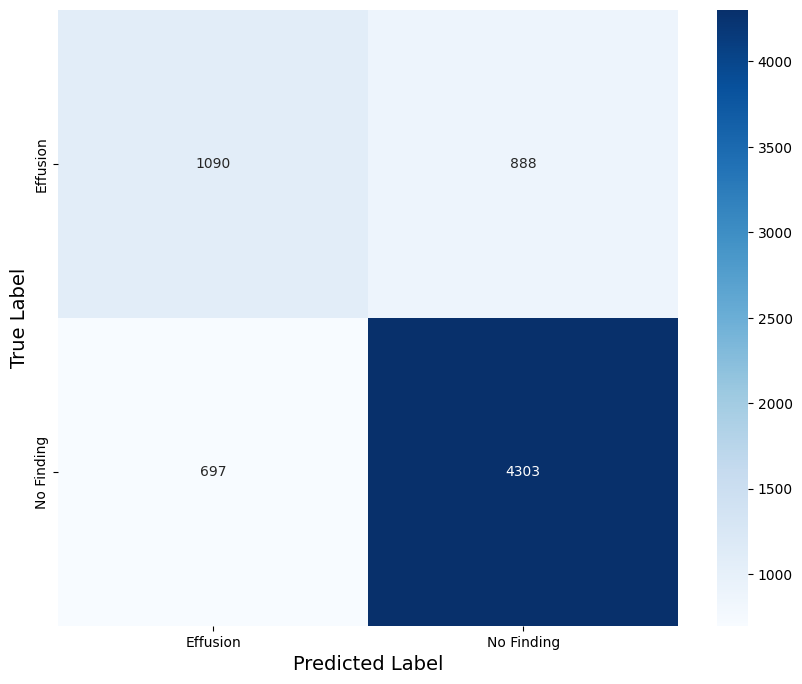

In [ ]:

class_names = train_dataset.class_names

y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)

plt.savefig("CNN_ConfusionMatrix_aug.pdf", format='pdf')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.61      0.55      0.58      1978
         1.0       0.83      0.86      0.84      5000

    accuracy                           0.77      6978
   macro avg       0.72      0.71      0.71      6978
weighted avg       0.77      0.77      0.77      6978



In [ ]:
model.save('cnn_augmentation.keras')

### Generated Eff, NoF = 6000

In [ ]:
model.build()
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_dataset_generated,
    epochs=30,
    validation_data=val_dataset,
)

history_dict = history.history
history_dict.keys()

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.7051 - loss: 0.5935 - val_accuracy: 0.7161 - val_loss: 0.5419
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7883 - loss: 0.4469 - val_accuracy: 0.7650 - val_loss: 0.5080
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8236 - loss: 0.3659 - val_accuracy: 0.7571 - val_loss: 0.4796
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8433 - loss: 0.3245 - val_accuracy: 0.7280 - val_loss: 0.5417
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8570 - loss: 0.3006 - val_accuracy: 0.7787 - val_loss: 0.4841
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8666 - loss: 0.2882 - val_accuracy: 0.7671 - val_loss: 0.5019
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8622 - loss: 0.2826 - val_accuracy: 0.7701 - val_loss: 0.5085
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8716 - loss: 0.2722 - val_acc

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
model.save('cnn_augmentation_Eff_Nof_6000.keras')

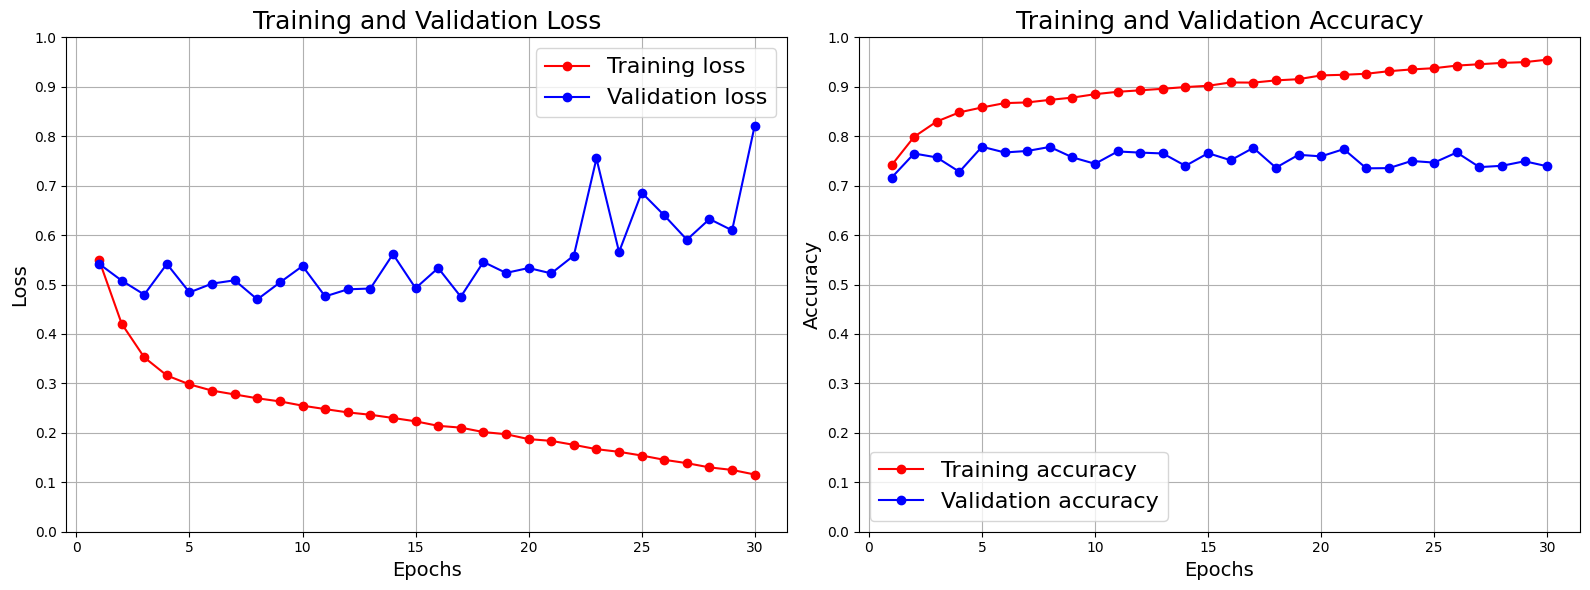

In [ ]:
epochs = range(1, len(history_dict['accuracy']) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(epochs, history_dict['loss'], 'r-o', label='Training loss')
ax1.plot(epochs, history_dict['val_loss'], 'b-o', label='Validation loss')
ax1.set_title('Training and Validation Loss', fontsize=18)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=16)

loss_ticks = np.arange(0, 1.1, 0.1)
ax1.set_yticks(loss_ticks)

ax2.plot(epochs, history_dict['accuracy'], 'r-o', label='Training accuracy')
ax2.plot(epochs, history_dict['val_accuracy'], 'b-o', label='Validation accuracy')
ax2.set_title('Training and Validation Accuracy', fontsize=18)
ax2.set_xlabel('Epochs', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.grid(True)
ax2.legend(fontsize=16)

accuracy_ticks = np.arange(0, 1.1, 0.1)
ax2.set_yticks(accuracy_ticks)

plt.tight_layout()
plt.savefig("CNN_training_aug.pdf", format='pdf')
plt.show()

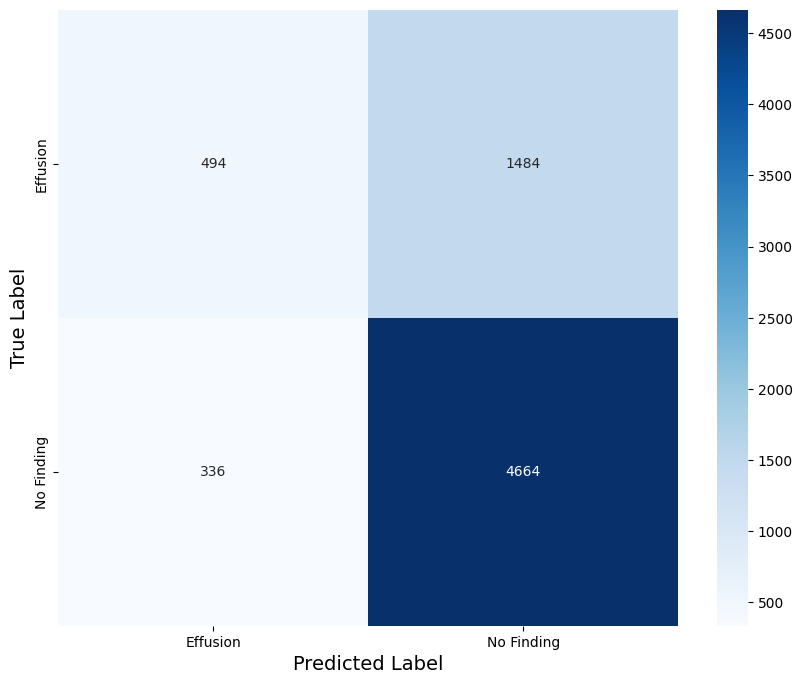

In [ ]:

class_names = train_dataset.class_names

y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)

plt.savefig("CNN_ConfusionMatrix_aug_Eff_NoF_6000.pdf", format='pdf')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.60      0.25      0.35      1978
         1.0       0.76      0.93      0.84      5000

    accuracy                           0.74      6978
   macro avg       0.68      0.59      0.59      6978
weighted avg       0.71      0.74      0.70      6978

